In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns   
import nltk 
from nltk.corpus import stopwords
import tqdm
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter


# Web Mining and Applied NLP (44-620)

## Final Project: Article Summarizer

### Student Name: Philip Fowler

Perform the tasks described in the Markdown cells below.  When you have completed the assignment make sure your code cells have all been run (and have output beneath them) and ensure you have committed and pushed ALL of your changes to your assignment repository.

You should bring in code from previous assignments to help you answer the questions below.

Every question that requires you to write code will have a code cell underneath it; you may either write your entire solution in that cell or write it in a python file (`.py`), then import and run the appropriate code to answer the question.

1. Find on the internet an article or blog post about a topic that interests you and you are able to get the text for using the technologies we have applied in the course.  Get the html for the article and store it in a file (which you must submit with your project)

In [37]:
# This is how the data was downloaded using the Kaggle API
# The data is already in the data folder, thus, it is now commented out
# The most challenging part was to install the Kaggle API and to set up the API key 
# I initially put the API key in the wrong place.  usr/bin/kaggle.json is the correct location  

# import kagglehub
# import shutil
# import os

# Download latest version
# path = kagglehub.dataset_download("austinreese/trump-tweets")

# Create data directory if it doesn't exist
# data_dir = "data"
# if not os.path.exists(data_dir):
#    os.makedirs(data_dir)

# Move downloaded files to data directory
# for file_name in os.listdir(path):
#    full_file_name = os.path.join(path, file_name)
#    if os.path.isfile(full_file_name):
#        shutil.move(full_file_name, data_dir)

# print("Files have been moved to the data folder.")

In [38]:
# Load the CSV file into a dataframe
df_trump_tweets = pd.read_csv('data/realdonaldtrump.csv')
print(df_trump_tweets.head())

           id                                               link  \
0  1698308935  https://twitter.com/realDonaldTrump/status/169...   
1  1701461182  https://twitter.com/realDonaldTrump/status/170...   
2  1737479987  https://twitter.com/realDonaldTrump/status/173...   
3  1741160716  https://twitter.com/realDonaldTrump/status/174...   
4  1773561338  https://twitter.com/realDonaldTrump/status/177...   

                                             content                 date  \
0  Be sure to tune in and watch Donald Trump on L...  2009-05-04 13:54:25   
1  Donald Trump will be appearing on The View tom...  2009-05-04 20:00:10   
2  Donald Trump reads Top Ten Financial Tips on L...  2009-05-08 08:38:08   
3  New Blog Post: Celebrity Apprentice Finale and...  2009-05-08 15:40:15   
4  "My persona will never be that of a wallflower...  2009-05-12 09:07:28   

   retweets  favorites mentions hashtags  
0       510        917      NaN      NaN  
1        34        267      NaN      NaN  

In [39]:
# Select the columns 'content' and 'date' from the dataframe
df_content_date = df_trump_tweets[['content', 'date']]

# Save the selected columns to an HTML file
df_content_date.to_html('trumptweets.html', index=False)

2. Read in your article's html source from the file you created in question 1 and do sentiment analysis on the article/post's text (use `.get_text()`).  Print the polarity score with an appropriate label.  Additionally print the number of sentences in the original article (with an appropriate label)

In [40]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment
def get_vader_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']

# Apply the function to the 'content' column and create a new column 'vader_sentiment'
df_trump_tweets['vader_sentiment'] = df_trump_tweets['content'].apply(get_vader_sentiment)

# Display the DataFrame
print(df_trump_tweets[['content', 'vader_sentiment']].head())
print(df_trump_tweets[['content', 'vader_sentiment']].tail())


                                             content  vader_sentiment
0  Be sure to tune in and watch Donald Trump on L...           0.5255
1  Donald Trump will be appearing on The View tom...           0.7712
2  Donald Trump reads Top Ten Financial Tips on L...           0.6468
3  New Blog Post: Celebrity Apprentice Finale and...           0.0000
4  "My persona will never be that of a wallflower...           0.0000
                                                 content  vader_sentiment
43347  Joe Biden was a TOTAL FAILURE in Government. H...          -0.7469
43348  Will be interviewed on @ seanhannity tonight a...           0.5411
43349                         pic.twitter.com/3lm1spbU8X           0.0000
43350                         pic.twitter.com/vpCE5MadUz           0.0000
43351                         pic.twitter.com/VLlc0BHW41           0.0000


In [41]:
# There is no point analyzing the rows that contain pic.twitter.com  can't do much with that.
# Count the number of rows containing 'pic.twitter.com'
count = df_trump_tweets['content'].str.contains('pic.twitter.com').sum()

print(f"Number of rows containing 'pic.twitter.com': {count}")

Number of rows containing 'pic.twitter.com': 3685


In [42]:
#let's delete the rows containing 'pic.twitter.com'
df_trump_tweets = df_trump_tweets[~df_trump_tweets['content'].str.contains('pic.twitter.com')]  

count = df_trump_tweets['content'].str.contains('pic.twitter.com').sum()
print(f"Number of rows containing 'pic.twitter.com': {count}")
print(df_trump_tweets.info())

Number of rows containing 'pic.twitter.com': 0
<class 'pandas.core.frame.DataFrame'>
Index: 39667 entries, 0 to 43348
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               39667 non-null  int64  
 1   link             39667 non-null  object 
 2   content          39667 non-null  object 
 3   date             39667 non-null  object 
 4   retweets         39667 non-null  int64  
 5   favorites        39667 non-null  int64  
 6   mentions         19216 non-null  object 
 7   hashtags         4116 non-null   object 
 8   vader_sentiment  39667 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 3.0+ MB
None


3. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent tokens (converted to lower case).  Print the common tokens with an appropriate label.  Additionally, print the tokens their frequencies (with appropriate labels)

In [43]:
# Load the English model
nlp = spacy.load('en_core_web_sm')

# Concatenate all text in the 'content' column
all_text = ' '.join(df_trump_tweets['content'].astype(str).tolist())

# Check the length of the text
text_length = len(all_text)
print(f"Text length: {text_length}")

# Increase the max_length limit
nlp.max_length = text_length + 1000  # Adding a buffer to the length

# Process the text with spacy
doc = nlp(all_text)

# Extract tokens, convert to lower case, and filter out stop words and punctuation
tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct]

# Get the five most common tokens
token_freq = Counter(tokens).most_common(5)

# Print the five most common tokens and their frequencies
for token, freq in token_freq:
    print(f"Token: {token}, Frequency: {freq}")

Text length: 5272985
Token: realdonaldtrump, Frequency: 8402
Token: great, Frequency: 6033
Token: trump, Frequency: 5541
Token: president, Frequency: 2851
Token: people, Frequency: 2568


4. Load the article text into a trained `spaCy` pipeline, and determine the 5 most frequent lemmas (converted to lower case).  Print the common lemmas with an appropriate label.  Additionally, print the lemmas with their frequencies (with appropriate labels).

In [44]:
# Load the English model
nlp = spacy.load('en_core_web_sm')

# Concatenate all text in the 'content' column
all_text = ' '.join(df_trump_tweets['content'].astype(str).tolist())

# Check the length of the text
text_length = len(all_text)
print(f"Text length: {text_length}")

# Increase the max_length limit
nlp.max_length = text_length + 1000  # Adding a buffer to the length

# Process the text with spacy
doc = nlp(all_text)

# Extract lemmas, convert to lower case, and filter out stop words and punctuation
lemmas = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]

# Get the five most common lemmas
lemma_freq = Counter(lemmas).most_common(5)

# Print the five most common lemmas and their frequencies
for lemma, freq in lemma_freq:
    print(f"Lemma: {lemma}, Frequency: {freq}")

Text length: 5272985
Lemma: realdonaldtrump, Frequency: 8402
Lemma: great, Frequency: 6342
Lemma: trump, Frequency: 5575
Lemma: thank, Frequency: 4149
Lemma: president, Frequency: 2907


5. Make a list containing the scores (using tokens) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores. From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

In [49]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the English model
nlp = spacy.load('en_core_web_sm')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment score for a given text using tokens
def get_token_score(text):
    doc = nlp(text)
    token_scores = [analyzer.polarity_scores(token.text)['compound'] for token in doc if not token.is_stop and not token.is_punct]
    return sum(token_scores) / len(token_scores) if token_scores else 0

# Function to calculate sentiment score for a given text using lemmas
def get_lemma_score(text):
    doc = nlp(text)
    lemma_scores = [analyzer.polarity_scores(token.lemma_)['compound'] for token in doc if not token.is_stop and not token.is_punct]
    return sum(lemma_scores) / len(lemma_scores) if lemma_scores else 0

# Apply the functions to the 'content' column and create new columns 'token_score' and 'lemma_score'
df_trump_tweets['token_score'] = df_trump_tweets['content'].apply(get_token_score)
df_trump_tweets['lemma_score'] = df_trump_tweets['content'].apply(get_lemma_score)

# Display the DataFrame with the new columns
print(df_trump_tweets[['content', 'token_score', 'lemma_score']].head())

                                             content  token_score  lemma_score
0  Be sure to tune in and watch Donald Trump on L...     0.026517     0.026517
1  Donald Trump will be appearing on The View tom...     0.068614     0.068614
2  Donald Trump reads Top Ten Financial Tips on L...     0.044040     0.044040
3  New Blog Post: Celebrity Apprentice Finale and...     0.000000     0.000000
4  "My persona will never be that of a wallflower...     0.000000     0.000000


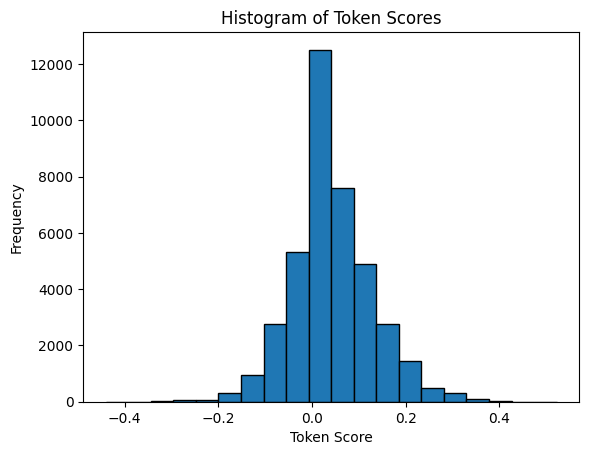

In [50]:
# Plot the histogram of the token_score column
plt.hist(df_trump_tweets['token_score'], bins=20, edgecolor='black')
plt.title('Histogram of Token Scores')
plt.xlabel('Token Score')
plt.ylabel('Frequency')
plt.show()

In [51]:
# Calculate statistics for the 'token_score' column
mean_score = df_trump_tweets['token_score'].mean()
median_score = df_trump_tweets['token_score'].median()
mode_score = df_trump_tweets['token_score'].mode()[0]  # mode() returns a Series, take the first value
max_score = df_trump_tweets['token_score'].max()
min_score = df_trump_tweets['token_score'].min()
range_score = max_score - min_score
std_deviation_score = df_trump_tweets['token_score'].std()

# Print the statistics
print(f"Mean: {mean_score}")
print(f"Median: {median_score}")
print(f"Mode: {mode_score}")
print(f"Max: {max_score}")
print(f"Min: {min_score}")
print(f"Range: {range_score}")
print(f"Standard Deviation: {std_deviation_score}")

Mean: 0.03968927391214934
Median: 0.02848
Mode: 0.0
Max: 0.52235
Min: -0.4404
Range: 0.96275
Standard Deviation: 0.08696466991534824


6. Make a list containing the scores (using lemmas) of every sentence in the article, and plot a histogram with appropriate titles and axis labels of the scores.  From your histogram, what seems to be the most common range of scores (put the answer in a comment after your code)?

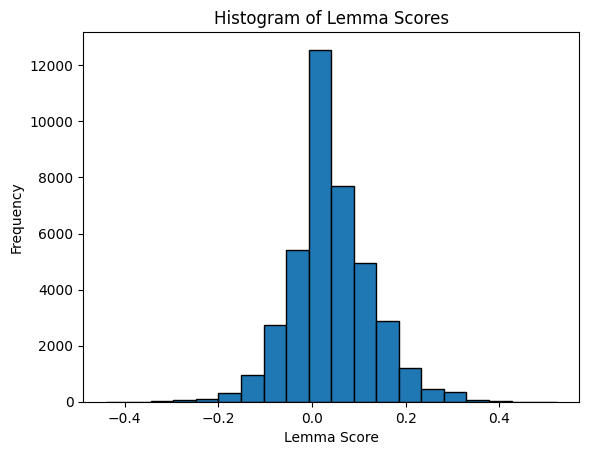

In [ ]:
# Lemma score was calculated in a previous step.  No reason to recalculate here.
# Plot the histogram of the lemma_score column
plt.hist(df_trump_tweets['lemma_score'], bins=20, edgecolor='black')
plt.title('Histogram of Lemma Scores')
plt.xlabel('Lemma Score')
plt.ylabel('Frequency')
plt.show()

In [54]:
# Calculate statistics for the 'lemma_score' column
mean_score = df_trump_tweets['lemma_score'].mean()
median_score = df_trump_tweets['lemma_score'].median()
mode_score = df_trump_tweets['lemma_score'].mode()[0]  # mode() returns a Series, take the first value
max_score = df_trump_tweets['lemma_score'].max()
min_score = df_trump_tweets['lemma_score'].min()
range_score = max_score - min_score
std_deviation_score = df_trump_tweets['lemma_score'].std()

# Print the statistics
print(f"Mean: {mean_score}")
print(f"Median: {median_score}")
print(f"Mode: {mode_score}")
print(f"Max: {max_score}")
print(f"Min: {min_score}")
print(f"Range: {range_score}")
print(f"Standard Deviation: {std_deviation_score}")

Mean: 0.0386645034520253
Median: 0.028478571428571426
Mode: 0.0
Max: 0.52235
Min: -0.4404
Range: 0.96275
Standard Deviation: 0.08541845257232926


7. Using the histograms from questions 5 and 6, decide a "cutoff" score for tokens and lemmas such that fewer than half the sentences would have a score greater than the cutoff score.  Record the scores in this Markdown cell

* Cutoff Score (tokens): 
* Cutoff Score (lemmas):

Feel free to change these scores as you generate your summaries.  Ideally, we're shooting for at least 6 sentences for our summary, but don't want more than 10 (these numbers are rough estimates; they depend on the length of your article).

In [55]:
# Calculate the median cutoff scores using the existing 'token_score' and 'lemma_score' columns
token_cutoff_score = df_trump_tweets['token_score'].median()
lemma_cutoff_score = df_trump_tweets['lemma_score'].median()

# Print the cutoff scores
print(f"Token Cutoff Score: {token_cutoff_score}")
print(f"Lemma Cutoff Score: {lemma_cutoff_score}")

Token Cutoff Score: 0.02848
Lemma Cutoff Score: 0.028478571428571426


8. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on tokens) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

In [59]:
from transformers import pipeline

# Specify the model to use for summarization
model_name = "sshleifer/distilbart-cnn-12-6"  # You can change this to any other model

# Initialize the summarization pipeline with the specified model
summarizer = pipeline("summarization", model=model_name)

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to summarize text
def summarize_text(text):
    # Summarize the text using the transformer model
    summary = summarizer(text, max_length=50, min_length=25, do_sample=False)
    return summary[0]['summary_text']

# Function to calculate polarity score
def get_polarity_score(text):
    return analyzer.polarity_scores(text)['compound']

# Ensure the 'date' column is in datetime format
df_trump_tweets['date'] = pd.to_datetime(df_trump_tweets['date'])

# Extract month and year from the 'date' column
df_trump_tweets['month'] = df_trump_tweets['date'].dt.month
df_trump_tweets['year'] = df_trump_tweets['date'].dt.year

# Group by year and month
grouped = df_trump_tweets.groupby(['year', 'month'])

# Create a new DataFrame to store the summaries
summaries = []

for (year, month), group in grouped:
    # Concatenate all text in the group
    all_text = ' '.join(group['content'].astype(str).tolist())
    # Summarize the concatenated text
    summary = summarize_text(all_text)
    # Calculate the polarity score of the summary
    polarity_score = get_polarity_score(summary)
    # Append the results to the summaries list
    summaries.append({'year': year, 'month': month, 'summary': summary, 'polarity_score': polarity_score})

# Create the new DataFrame
df_trump_tweet_summaries = pd.DataFrame(summaries)

# Display the new DataFrame
print(df_trump_tweet_summaries.head())

RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

9. Print the polarity score of your summary you generated with the token scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

10. Create a summary of the article by going through every sentence in the article and adding it to an (initially) empty list if its score (based on lemmas) is greater than the cutoff score you identified in question 8.  If your loop variable is named `sent`, you may find it easier to add `sent.text.strip()` to your list of sentences.  Print the summary (I would cleanly generate the summary text by `join`ing the strings in your list together with a space (`' '.join(sentence_list)`).

11. Print the polarity score of your summary you generated with the lemma scores (with an appropriate label). Additionally, print the number of sentences in the summarized article.

12.  Compare your polarity scores of your summaries to the polarity scores of the initial article.  Is there a difference?  Why do you think that may or may not be?.  Answer in this Markdown cell.  

13. Based on your reading of the original article, which summary do you think is better (if there's a difference).  Why do you think this might be?